In [58]:
import os
import json
from sklearn.model_selection import KFold


In [67]:
train_json = []
num_of_folds = 5

In [68]:
json_save_dir = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/files/'
data_dir = "/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/"
patients = os.listdir(data_dir)
len(patients)

524

In [69]:
# patients = patients[:5]
# len(patients)

In [70]:
full_indices = range(len(patients))

kf = KFold(n_splits=num_of_folds, shuffle=True, random_state=786)

for f in range(num_of_folds):
    

    train_idx = {}
    test_idx = {}

    key = 1
    for i,j in kf.split(full_indices):
        train_idx[key] = i
        test_idx[key] = j

        key += 1

    patients_test = [patients[i] for i in test_idx[f+1]]



    for p in patients_test:
        train_json_dict = {}
        train_json_dict["path"] = os.path.join(data_dir, p, p + ".pt")
        train_json_dict["fold"] = f
        # train_json_dict["ct"] = (os.path.join(p, (p + "_ct.nii.gz")))
        # train_json_dict["pt"] = (os.path.join(p, (p + "_pt.nii.gz")))
        # train_json_dict["seg"] = (os.path.join(p, (p + "_gt.nii.gz")))
        train_json.append(train_json_dict)


In [71]:
train_json_final = {"training": train_json}

In [72]:
train_json_final

{'training': [{'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/CHUV-008/CHUV-008.pt',
   'fold': 0},
  {'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/MDA-024/MDA-024.pt',
   'fold': 0},
  {'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/CHUS-052/CHUS-052.pt',
   'fold': 0},
  {'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/MDA-147/MDA-147.pt',
   'fold': 0},
  {'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/CHUS-049/CHUS-049.pt',
   'fold': 0},
  {'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/CHUS-026/CHUS-026.pt',
   'fold': 0},
  {'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/MDA-028/MDA-028.pt',
   'fold': 0},
  {'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/HGJ-025/HGJ-025.pt',
   'fold': 0},
  {'path': '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/MDA-023/MDA-023.pt',
   'fold': 0},

In [73]:
with open(os.path.join(json_save_dir, "train_json_torch.json"), "w") as outfile:
    json.dump(train_json_final, outfile, indent=4)

#### Create pytorch files with transforms

In [23]:
import os

import matplotlib.pyplot as plt
import numpy as np
from monai import transforms

from monai.transforms import (
    LoadImaged,
    Orientationd,
    MapTransform,
    ScaleIntensityd,
    SpatialPadd,
    ConcatItemsd,
    NormalizeIntensityd,
)

import json
import gzip

import io

import torch

In [5]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            # elif key == "pt":
            #     d[key] = torch.clip(d[key], d[key].min(), 5)
        return d
class MulPTFM(MapTransform):
    """
    Mult PT and FM 

    """

    def __call__(self, data):
        d = dict(data)

        fm = d["ct"] > 0
        d["pt"] = d["pt"] * fm
        return d
class SelectClass(MapTransform):
    """
    Select the class for which you want to fine tune the model 

    """
    # def __init__(self, keys, cls=1):
    #     super(self).__init__(keys)
    #     self.cls = cls

    def __call__(self, data):
        d = dict(data)
        d["seg"][d["seg"] == 1] = 0
        # d["seg"][d["seg"] == 2] = 1
        
        return d

In [6]:
data_dir = '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/'
save_dir = '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_torch/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [7]:
patients = os.listdir(data_dir)
len(patients)

524

In [8]:
val_transform = transforms.Compose(
        [
            LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
            SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(200,200,310), method='end'),
            Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
            NormalizeIntensityd(keys=["pt"]),
            ClipCT(keys=["ct"]),
            ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
            #MulPTFM(keys=["ct","pt"]),
            ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
            ]
        )

/home/ikboljonsobirov/.conda/envs/sega/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [9]:
data_dir

'/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/'

In [57]:
for p in patients:
    path_patient_ct = os.path.join(data_dir, p, p + "_ct.nii.gz")
    path_patient_pt = os.path.join(data_dir, p, p + "_pt.nii.gz")
    path_patient_gt = os.path.join(data_dir, p, p + "_gt.nii.gz")

    data = {"id": p, "ct": path_patient_ct, "pt": path_patient_pt, "seg": path_patient_gt}
    transformed_data = val_transform(data)

    transformed_data.pop("ct_meta_dict", None)
    transformed_data.pop("pt_meta_dict", None)
    transformed_data.pop("seg_meta_dict", None)
    transformed_data.pop("ct", None)
    transformed_data.pop("pt", None)

    print(p, transformed_data.keys(), transformed_data["ctpt"].shape, transformed_data["seg"].shape)


    if not os.path.exists(os.path.join(save_dir, p)):
        os.makedirs(os.path.join(save_dir, p))
    
        
    torch.save(transformed_data, os.path.join(save_dir, p, p + ".pt"))
    # with gzip.open(os.path.join(save_dir, p, p + ".pt.gz"), "wb") as f:
    #     torch.save(transformed_data, f)
    # break

HGJ-082 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
CHUV-008 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
CHUP-010 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
MDA-090 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
CHUV-002 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
CHUV-046 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
CHUV-011 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
MDA-034 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
MDA-146 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 310]) torch.Size([1, 200, 200, 310])
CHUS-081 dict_keys(['id', 'seg', 'ctpt']) torch.Size([2, 200, 200, 3

In [52]:
new_data = torch.load(os.path.join(save_dir, p, p + ".pt"))

In [53]:
pat_path = os.path.join(save_dir, p, p + ".pt.gz")

In [54]:
with gzip.open(pat_path, "rb") as f:
    tensor = torch.load(f)

In [55]:
tensor['id'], tensor['ctpt'].shape, tensor['seg'].shape

('HGJ-082', torch.Size([2, 200, 200, 310]), torch.Size([1, 200, 200, 310]))

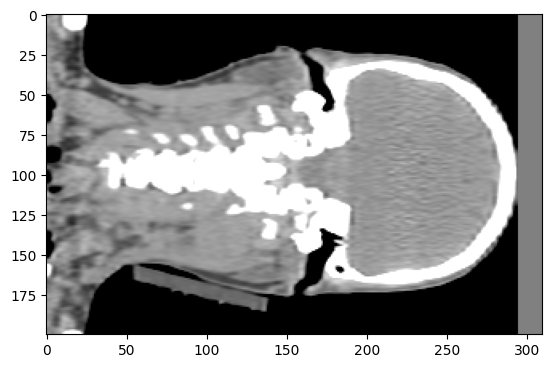

In [56]:
plt.imshow(new_data['ctpt'][1, 100, :, :], cmap='gray')